# Model Evaluation

In this notebook, we will evaluate the performance of our Kriging model for `NYS Oil & Gas Wells` dataset. We will assess the model’s accuracy and reliability using a range of spatial evaluation metrics. Our goal is to determine the most effective model for this task.

By the end of this notebook, we will identify the strongest model for predicting where to drill for energy, providing valuable insights for further analysis and real-world application.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pickle
import geopandas as gpd
from shapely.geometry import Point
import warnings, json
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

### Double Checking Saved Model

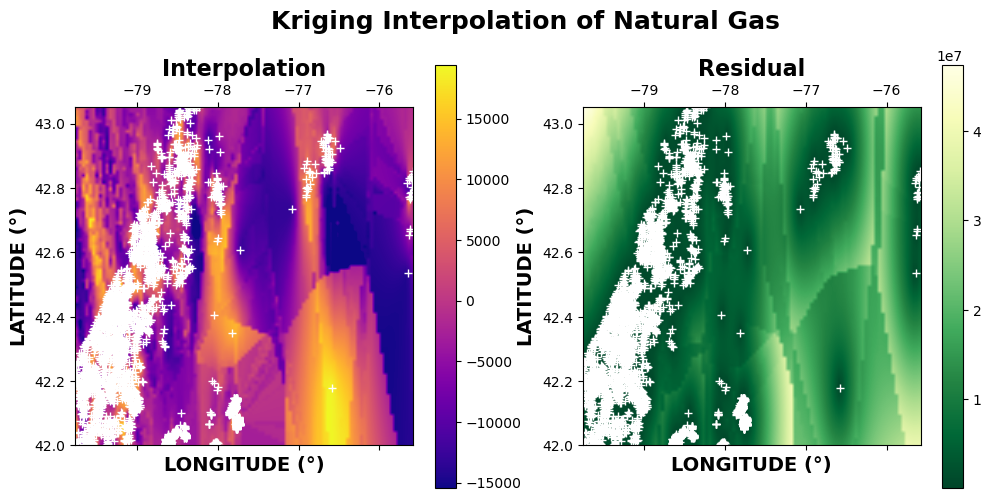

In [2]:
df = pd.read_csv('../data/encoded_gaswells.csv')
coords = np.array(df[['num__longitude', 'num__latitude']].values)
vals = np.array(df['num__gas_prod'].values)

x = coords[:, 0]
y = coords[:, 1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]

with open('../model/base_ordinary.pkl', 'rb') as f:
    kriging = pickle.load(f)

field = kriging.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = kriging.sigma.reshape(xx.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5.5))
gas_interp = ax1.matshow(field.T, origin='lower', cmap='plasma', 
                   interpolation='bilinear',
                   vmin=vals.min(), vmax=vals.max(),
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax1.set_title('Interpolation', fontweight='bold', fontsize=16)
ax1.plot(x, y, '+w')
ax1.set_xlabel('LONGITUDE (°)', color='black', fontweight='bold', fontsize=14)
ax1.set_ylabel('LATITUDE (°)', color='black', fontweight='bold', fontsize=14)
ax1.set_xlim((x.min(), x.max()))
ax1.set_ylim((y.min(), y.max()))
ax1.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax1.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(gas_interp, ax=ax1)

gas_error = ax2.matshow(s2.T, origin='lower', cmap='YlGn_r',
                   interpolation='bilinear',
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax2.set_title('Residual', fontweight='bold', fontsize=16)
ax2.plot(x, y, '+w')
ax2.set_xlabel('LONGITUDE (°)', color='black', fontweight='bold', fontsize=14)
ax2.set_ylabel('LATITUDE (°)', color='black', fontweight='bold', fontsize=14)
ax2.set_xlim((x.min(), x.max()))
ax2.set_ylim((y.min(), y.max()))
ax2.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax2.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(gas_error, ax=ax2)

fig.suptitle('Kriging Interpolation of Natural Gas\n\n', fontsize=18, fontweight='bold')
plt.show()
plt.tight_layout(rect=[0,0,1,0.95])
plt.close()

### Re-Adding County Data to Clean Gas Wells Data

In [3]:
df_county = pd.read_csv('../data/data_source/oilgas_wells.csv', low_memory=False)
df_county = df_county[['County','Bottom_hole_longitude','Bottom_hole_latitude']].copy()
df_county.rename(columns={'Bottom_hole_longitude':'longitude','Bottom_hole_latitude':'latitude'}, inplace=True)
df_county = df_county.drop_duplicates(subset=['longitude', 'latitude'])
print(df_county.head(),'\n','='*60)

df_wells = pd.read_csv('../data/clean_gaswells.csv')
print(df_wells.shape,'\n',df_wells.head(),'\n','='*60)

df_merged = pd.merge(df_wells, df_county, on=['longitude','latitude'], how='left')
df_merged = df_merged[['County','gas_prod','longitude','latitude','depth','elevation',
                       'well','status','field','geology']].copy()
print(df_merged.shape,'\n',df_merged.head(),'\n','='*60)
df_merged.to_csv('../data/county_gaswells.csv', index=False)

   County  longitude  latitude
0  Albany     -74.13     42.49
1  Albany     -73.91     42.64
2  Albany     -73.84     42.68
3  Albany     -73.84     42.68
4  Albany     -73.84     42.68 
(3691, 9) 
    gas_prod             well             status    depth  elevation  \
0  5,455.00  gas development  plugged abandoned 1,294.00     851.00   
1  4,741.00  gas development  plugged abandoned 1,818.00     535.00   
2 28,116.00  gas development           inactive 1,425.00     640.00   
3  4,226.00    gas extension  plugged abandoned 3,450.00   1,283.00   
4  4,966.00      oil wildcat             active 4,500.00   1,780.00   

   longitude  latitude                 field         geology  
0     -78.48     42.94       Alden-Lancaster          Medina  
1     -76.66     42.89           West Auburn       Queenston  
2     -78.92     42.73  Orchard Park-Hamburg          Medina  
3     -79.31     42.27       Cassadaga Creek  Upper Devonian  
4     -79.59     42.05                Clymer     Bass Islan

### Creating Grid Data for Dashboard Map

In [4]:
df = pd.read_csv('../data/county_gaswells.csv')
with open('../model/base_ordinary.pkl', 'rb') as f:
    kriging = pickle.load(f)

lat_min, lat_max = df.latitude.min(), df.latitude.max()
lon_min, lon_max = df.longitude.min(), df.longitude.max()
xx, yy = np.mgrid[lon_min:lon_max:100j, lat_min:lat_max:100j]

field = kriging.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = kriging.sigma.reshape(xx.shape)

grid_data = pd.DataFrame({
    'lat': yy.flatten(),
    'lon': xx.flatten(),
    'predicted_value': field.flatten(),
    'error': s2.flatten()})

geometry = [Point(xy) for xy in zip(grid_data['lon'], grid_data['lat'])]
gdf_grid = gpd.GeoDataFrame(grid_data, geometry=geometry)

with open('../data/new_york_counties.json') as f:
    counties = json.load(f)

gdf_county = gpd.GeoDataFrame.from_features(counties['features'])

gdf_grid_with_counties = gpd.sjoin(gdf_grid, gdf_county, how='left', op='within')
gdf_grid_with_counties.to_parquet('../data/kriging_grid_data.parquet')
print(gdf_grid_with_counties.head())

    lat    lon  predicted_value        error                    geometry  \
0 42.00 -79.76        -2,769.17   795,862.63  POINT (-79.76033 41.99982)   
1 42.01 -79.76         1,961.96   463,631.89  POINT (-79.76033 42.01043)   
2 42.02 -79.76         8,166.53   165,886.65  POINT (-79.76033 42.02104)   
3 42.03 -79.76        10,366.82   760,998.27  POINT (-79.76033 42.03165)   
4 42.04 -79.76        11,283.10 1,156,087.31  POINT (-79.76033 42.04226)   

   index_right STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME  \
0        49.00      36      013  00974105  0500000US36013  36013  Chautauqua   
1        49.00      36      013  00974105  0500000US36013  36013  Chautauqua   
2        49.00      36      013  00974105  0500000US36013  36013  Chautauqua   
3        49.00      36      013  00974105  0500000US36013  36013  Chautauqua   
4        49.00      36      013  00974105  0500000US36013  36013  Chautauqua   

  LSAD            ALAND           AWATER  
0   06 2,745,973,92

In [5]:
gdf = gpd.read_parquet('../data/kriging_grid_data.parquet')
gdf.describe()

,lat,lon,predicted_value,error,index_right,ALAND,AWATER
count,"10,000.00","10,000.00","10,000.00","10,000.00","8,886.00","8,886.00","8,886.00"
mean,42.53,-77.67,"-2,065.30","10,604,438.45",25.93,"2,170,438,575.91","200,944,898.44"
std,0.31,1.22,"8,207.20","9,308,733.34",16.45,"868,302,809.07","385,942,127.84"
min,42.00,-79.76,"-22,667.07","6,585.72",0.00,"838,403,626.00","6,142,605.00"
25%,42.26,-78.71,"-8,576.85","2,300,503.39",14.00,"1,535,218,840.00","13,153,776.00"
50%,42.53,-77.67,"-2,477.57","8,568,656.13",26.00,"1,827,924,125.00","36,246,374.00"
75%,42.79,-76.62,"3,659.14","16,941,489.71",37.00,"2,745,973,929.00","97,504,774.00"
max,43.05,-75.58,"19,463.79","47,442,279.93",58.00,"3,601,566,799.00","2,018,183,253.00"


In [6]:
gdf = gpd.read_parquet('../data/kriging_grid_data.parquet')
trend = pd.read_csv('../data/trend_removed.csv')
pred_fixed = gdf['predicted_value'] + trend['0']
gdf['predicted_value'] = pred_fixed
gdf.to_parquet('../data/kriging_grid_data.parquet', index=False)
gdf.describe()

,lat,lon,predicted_value,error,index_right,ALAND,AWATER
count,"10,000.00","10,000.00","3,691.00","10,000.00","8,886.00","8,886.00","8,886.00"
mean,42.53,-77.67,"11,993.67","10,604,438.45",25.93,"2,170,438,575.91","200,944,898.44"
std,0.31,1.22,"7,879.37","9,308,733.34",16.45,"868,302,809.07","385,942,127.84"
min,42.00,-79.76,"-10,940.81","6,585.72",0.00,"838,403,626.00","6,142,605.00"
25%,42.26,-78.71,"6,214.10","2,300,503.39",14.00,"1,535,218,840.00","13,153,776.00"
50%,42.53,-77.67,"11,525.43","8,568,656.13",26.00,"1,827,924,125.00","36,246,374.00"
75%,42.79,-76.62,"17,184.49","16,941,489.71",37.00,"2,745,973,929.00","97,504,774.00"
max,43.05,-75.58,"34,109.44","47,442,279.93",58.00,"3,601,566,799.00","2,018,183,253.00"


In [7]:
try:
    print('Script executed successfully.')
except:
    print('FAILED')

Script executed successfully.
